In [ ]:
from google.colab import drive


drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis = 0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

In [ ]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None # h : 다음계층으로 넘겨줄 RNN계층의 은닉상태
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # 미니배치 : N, 시계열 데이터 : T, 입력 벡터의 차원수 : D

        D, H = Wx.shape # H 은닉층의 노드 개수 : H

        self.layers = []
        hs = np.empty((N, T, H), dtype='f') 

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

In [ ]:

import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size 
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')   # Xavier 초기값 사용 randn에 루트 n을 나눠줌.
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')    # Xavier 초기값 사용
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')  # Xavier 초기값 사용
        affine_b = np.zeros(V).astype('f')


        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 405.90
| 에폭 2 | 퍼플렉서티 281.45
| 에폭 3 | 퍼플렉서티 230.83
| 에폭 4 | 퍼플렉서티 218.80
| 에폭 5 | 퍼플렉서티 208.16
| 에폭 6 | 퍼플렉서티 204.24
| 에폭 7 | 퍼플렉서티 199.75
| 에폭 8 | 퍼플렉서티 198.31
| 에폭 9 | 퍼플렉서티 192.62
| 에폭 10 | 퍼플렉서티 193.18
| 에폭 11 | 퍼플렉서티 189.80
| 에폭 12 | 퍼플렉서티 193.09
| 에폭 13 | 퍼플렉서티 190.37
| 에폭 14 | 퍼플렉서티 191.21
| 에폭 15 | 퍼플렉서티 190.06
| 에폭 16 | 퍼플렉서티 186.81
| 에폭 17 | 퍼플렉서티 184.11
| 에폭 18 | 퍼플렉서티 181.02
| 에폭 19 | 퍼플렉서티 181.89
| 에폭 20 | 퍼플렉서티 184.99
| 에폭 21 | 퍼플렉서티 183.22
| 에폭 22 | 퍼플렉서티 180.14
| 에폭 23 | 퍼플렉서티 176.92
| 에폭 24 | 퍼플렉서티 178.18
| 에폭 25 | 퍼플렉서티 175.94
| 에폭 26 | 퍼플렉서티 174.70
| 에폭 27 | 퍼플렉서티 173.56
| 에폭 28 | 퍼플렉서티 170.40
| 에폭 29 | 퍼플렉서티 166.92
| 에폭 30 | 퍼플렉서티 163.81
| 에폭 31 | 퍼플렉서티 165.70
| 에폭 32 | 퍼플렉서티 158.69
| 에폭 33 | 퍼플렉서티 160.33
| 에폭 34 | 퍼플렉서티 157.01
| 에폭 35 | 퍼플렉서티 154.55
| 에폭 36 | 퍼플렉서티 146.96
| 에폭 37 | 퍼플렉서티 147.29
| 에폭 38 | 퍼플렉서티 141.49
| 에폭 39 | 퍼플렉서티 135.38
| 에폭 40 | 퍼플렉서티 132.27
| 에폭 41 | 퍼플렉서티 131.25
| 에폭 42 | 퍼플렉서티 126.04
| 에폭 43 | 퍼플렉서티 118

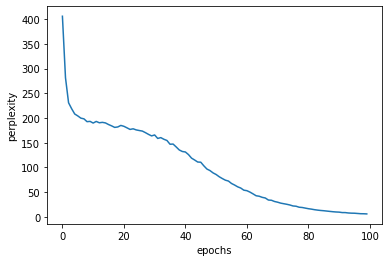

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb



# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
